Скачаем репозиторий проекта lime_imag и установим lime

In [1]:
!git clone https://github.com/marcotcr/lime.git

Cloning into 'lime'...
remote: Enumerating objects: 2389, done.
remote: Total 2389 (delta 0), reused 0 (delta 0), pack-reused 2389
Receiving objects: 100% (2389/2389), 21.41 MiB | 20.89 MiB/s, done.
Resolving deltas: 100% (1600/1600), done.


In [2]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=a44b965e1f910c81252182146277ac8f1aef6a028472c71f4376ceefcb6b9136
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import gray2rgb, rgb2gray, label2rgb # поскольку код требует цветных изображений

In [4]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784')
mnist_data = mnist.data.values.astype(np.uint8)
X_vec = np.stack([gray2rgb(iimg) for iimg in mnist_data.reshape((-1, 28, 28))], 0).astype(np.uint8)
y_vec = mnist.target.astype(np.uint8)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Text(0.5, 1.0, 'Digit: 5')

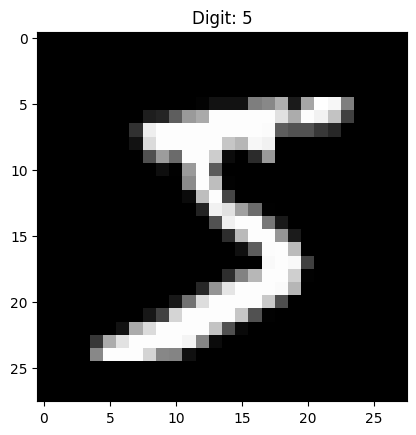

In [5]:
%matplotlib inline
fig, ax1 = plt.subplots(1,1)
ax1.imshow(X_vec[0], interpolation = 'none')
ax1.set_title('Digit: {}'.format(y_vec[0]))

Настройка конвейера

Здесь мы создаем конвейер для обработки изображений, где, по сути, сплющиваем изображение в 1d-векторы, а затем используем классификатор RandomForest.

In [6]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Normalizer

class PipeStep(object):
    """
    Обертка для превращения функций в конвейерные преобразования (без подгонки)
    """
    def __init__(self, step_func):
        self._step_func=step_func
    def fit(self,*args):
        return self
    def transform(self,X):
        return self._step_func(X)


makegray_step = PipeStep(lambda img_list: [rgb2gray(img) for img in img_list])
flatten_step = PipeStep(lambda img_list: [img.ravel() for img in img_list])

simple_rf_pipeline = Pipeline([
    ('Make Gray', makegray_step),
    ('Flatten Image', flatten_step),
    #('Normalize', Normalizer()),
    #('PCA', PCA(16)),
    ('RF', RandomForestClassifier())
                              ])

In [7]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec,
                                                    train_size=0.55)

In [8]:
simple_rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('Make Gray', <__main__.PipeStep object at 0x78d177278dc0>),
                ('Flatten Image', <__main__.PipeStep object at 0x78d177278f10>),
                ('RF', RandomForestClassifier())])

In [9]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # добавить текущую директорию
    import lime

Расширение автозагрузки уже загружено. Чтобы перезагрузить его, используйте:
   %reload_ext autoreload

In [10]:
from lime import lime_image
from lime.wrappers.scikit_image import SegmentationAlgorithm
explainer = lime_image.LimeImageExplainer(verbose = False)
segmenter = SegmentationAlgorithm('quickshift', kernel_size=1, max_dist=200, ratio=0.2)

In [11]:
%%time
explanation = explainer.explain_instance(X_test[0],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 6.59 s, sys: 154 ms, total: 6.74 s
Wall time: 6.9 s


Text(0.5, 1.0, 'Положительные/отрицательные регионы для 7')

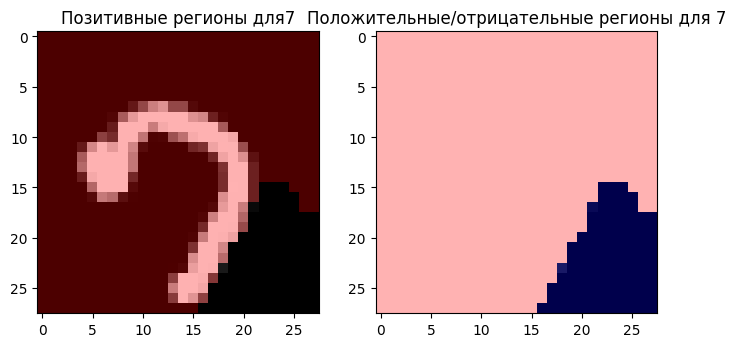

In [12]:
temp, mask = explanation.get_image_and_mask(y_test.iloc[0], positive_only=True, num_features=10, hide_rest=False, min_weight=0.01)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(label2rgb(mask, temp, bg_label=0), interpolation='nearest')
ax1.set_title('Позитивные регионы для{}'.format(y_test.iloc[0]))

temp, mask = explanation.get_image_and_mask(y_test.iloc[0], positive_only=False, num_features=10, hide_rest=False, min_weight=0.01)
ax2.imshow(label2rgb(3 - mask, temp, bg_label=0), interpolation='nearest')
ax2.set_title('Положительные/отрицательные регионы для {}'.format(y_test.iloc[0]))

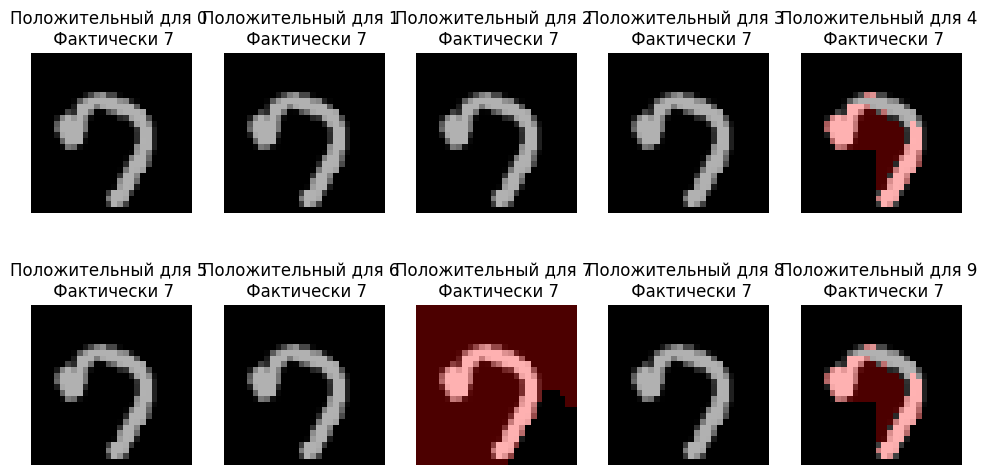

In [13]:
# теперь покаем их для каждого класса
fig, m_axs = plt.subplots(2, 5, figsize=(12, 6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=1000, hide_rest=False, min_weight=0.01)
    c_ax.imshow(label2rgb(mask, X_test[0], bg_label=0), interpolation='nearest')
    c_ax.set_title('Положительный для {} \n Фактически {}'.format(i, y_test.iloc[0]))
    c_ax.axis('off')

In [14]:
pipe_pred_test = simple_rf_pipeline.predict(X_test)
wrong_idx = np.random.choice(np.where(pipe_pred_test!=y_test)[0])
print('Используем #{} где метка была {}, а конвейер предсказал {}'.format(wrong_idx, y_test[wrong_idx], pipe_pred_test[wrong_idx]))

Используем #14193 где метка была 4, а конвейер предсказал 2


In [15]:
%%time
explanation = explainer.explain_instance(X_test[wrong_idx],
                                         classifier_fn = simple_rf_pipeline.predict_proba,
                                         top_labels=10, hide_color=0, num_samples=10000, segmentation_fn=segmenter)

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 8.14 s, sys: 158 ms, total: 8.3 s
Wall time: 12.6 s


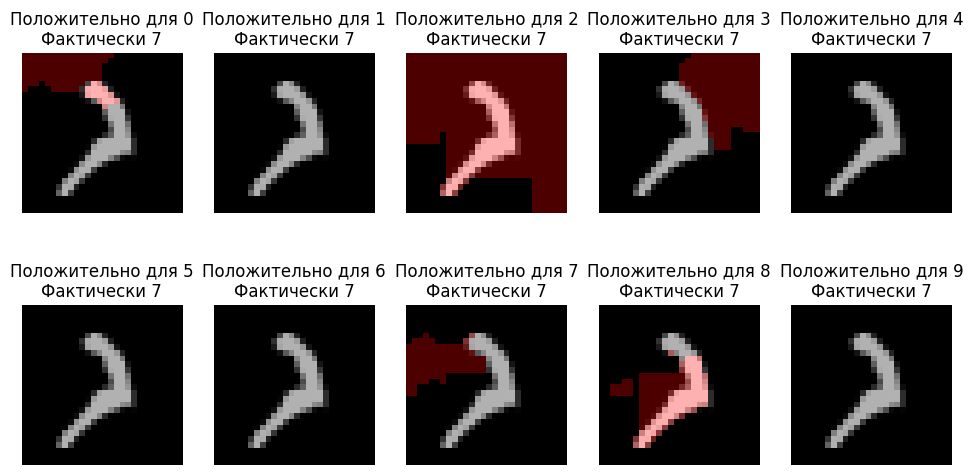

In [16]:
# теперь покажем их для каждого класса
fig, m_axs = plt.subplots(2,5, figsize = (12,6))
for i, c_ax in enumerate(m_axs.flatten()):
    temp, mask = explanation.get_image_and_mask(i, positive_only=True, num_features=10, hide_rest=False, min_weight = 0.01 )
    c_ax.imshow(label2rgb(mask,temp, bg_label = 0), interpolation = 'nearest')
    c_ax.set_title('Положительно для {}\nФактически {}'.format(i, y_test.iloc[wrong_idx]))
    c_ax.axis('off')